## Notebook for execution of training and evaluation of the model.

In [1]:
import pandas as pd

df = pd.read_csv('../data/raw/pre-processed.csv')
print(df.iloc[-1])


index                                                             7199
label                                                             true
preprocessed_news    envolvo politica diz brasileiro preso venezuel...
Name: 7199, dtype: object


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load preprocessed data
df = pd.read_csv('../data/raw/pre-processed.csv')  

# Confirm class balance
print(df['label'].value_counts())

# Split: 70% train, 15% val, 15% test
df_train, df_temp = train_test_split(
    df, test_size=0.30, stratify=df['label'], random_state=42
)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42
)

print("Train size:", len(df_train))
print("Val size:", len(df_val))
print("Test size:", len(df_test))

# Save splits
df_train.to_csv('../data/processed/train.csv', index=False)
df_val.to_csv('../data/processed/val.csv', index=False)
df_test.to_csv('../data/processed/test.csv', index=False)


label
fake    3600
true    3600
Name: count, dtype: int64
Train size: 5040
Val size: 1080
Test size: 1080


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Load splits
df_train = pd.read_csv('../data/processed/train.csv')
df_val = pd.read_csv('../data/processed/val.csv')
df_test = pd.read_csv('../data/processed/test.csv')

# Prepare features and labels
X_train, y_train = df_train['preprocessed_news'], df_train['label']
X_val, y_val = df_val['preprocessed_news'], df_val['label']
X_test, y_test = df_test['preprocessed_news'], df_test['label']

# TF-IDF Vectorizer (fit only on train!)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_val_vec = tfidf.transform(X_val)
X_test_vec = tfidf.transform(X_test)

# Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_vec, y_train)

# Validation metrics
val_pred = clf.predict(X_val_vec)
print("Validation Metrics:")
print(classification_report(y_val, val_pred))

# Test metrics
test_pred = clf.predict(X_test_vec)
print("Test Metrics:")
print(classification_report(y_test, test_pred))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred))


Validation Metrics:
              precision    recall  f1-score   support

        fake       0.94      0.97      0.96       540
        true       0.97      0.94      0.95       540

    accuracy                           0.96      1080
   macro avg       0.96      0.96      0.96      1080
weighted avg       0.96      0.96      0.96      1080

Test Metrics:
              precision    recall  f1-score   support

        fake       0.93      0.97      0.95       540
        true       0.97      0.93      0.95       540

    accuracy                           0.95      1080
   macro avg       0.95      0.95      0.95      1080
weighted avg       0.95      0.95      0.95      1080

Confusion Matrix (Test):
[[525  15]
 [ 37 503]]


count    7200.000000
mean      366.438194
std       379.080044
min         5.000000
25%        92.000000
50%       210.000000
75%       525.000000
max      4229.000000
Name: len, dtype: float64
0.50     210.00
0.75     525.00
0.90     889.00
0.95    1124.05
0.99    1567.20
Name: len, dtype: float64


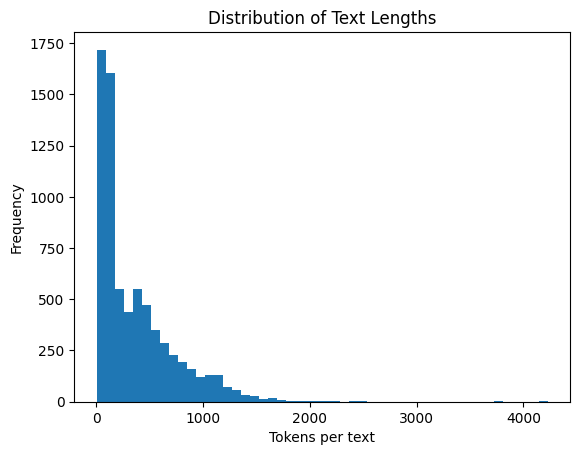

In [13]:
import pandas as pd

df = pd.read_csv('../data/raw/pre-processed.csv')  # or wherever you load your data

# Add this block to profile input lengths
df['len'] = df['preprocessed_news'].apply(lambda x: len(str(x).split()))
print(df['len'].describe())
print(df['len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99]))  # medians, percentiles

# Optional: visualize with a histogram
import matplotlib.pyplot as plt
plt.hist(df['len'], bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Tokens per text")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np
import pandas as pd

# Check CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model/tokenizer (use 'neuralmind/bert-base-portuguese-cased' for BERTimbau)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)
model.eval()

# Parameters
BATCH_SIZE = 8  # Adjust for your GPU memory 
MAX_LEN = 512  # Adjust for your data length

# Texts to embed
texts = df["preprocessed_news"].tolist()

# Batched embedding function
def get_embeddings_batch(texts, model, tokenizer, batch_size=32, max_len=128, device='cpu'):
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i+batch_size]
            encodings = tokenizer(batch_texts, 
                                  return_tensors='pt', 
                                  padding=True, 
                                  truncation=True, 
                                  max_length=max_len)
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # CLS token embedding for each item in batch
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

embeddings = get_embeddings_batch(
    texts, model, tokenizer, batch_size=BATCH_SIZE, max_len=MAX_LEN, device=device
)
print("Embeddings shape:", embeddings.shape)
np.save('outputs/embeddings_bertbase.npy', embeddings)
df['label'].to_csv('outputs/labels.csv', index=False)


Using device: cuda


 13%|█▎        | 113/900 [00:32<03:45,  3.49it/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Load embeddings and labels
embeddings = np.load('outputs/embeddings_bertbase.npy')
labels = pd.read_csv('outputs/labels.csv').values.ravel()  # ravel() to flatten to 1D

# Split (use the same indices as train/val/test if you did this before embedding)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

# Train classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


SyntaxError: invalid non-printable character U+00A0 (3745882828.py, line 9)